## mPyPl: Monadic Way to do Complex Data Processing in Python

This notebook contains materials from the presentations at PyCon Estonia, PyCon Balkan and SECR.

In [37]:
import sys
!{sys.executable} -m pip install --upgrade mPyPl

  Found existing installation: mPyPl 0.0.3.7
    Uninstalling mPyPl-0.0.3.7:
      Successfully uninstalled mPyPl-0.0.3.7
You should consider upgrading via the 'pip install --upgrade pip' command.


### The Pain of Python

Computing frequency dictionary of a text file

In [2]:
!wget https://www.gutenberg.org/files/11/11-0.txt
!mv 11-0.txt alice.txt

--2019-10-01 18:51:06--  https://www.gutenberg.org/files/11/11-0.txt
Resolving webproxy (webproxy)... 10.36.62.1
Connecting to webproxy (webproxy)|10.36.62.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 173595 (170K) [text/plain]
Saving to: ‘11-0.txt’

11-0.txt            100%[===================>] 169.53K   915KB/s    in 0.2s    

2019-10-01 18:51:07 (915 KB/s) - ‘11-0.txt’ saved [173595/173595]



In [1]:
from itertools import groupby
import matplotlib.pyplot as plt

txt = open('alice.txt','r').readlines()
words = sum(map(lambda x: x.lower().strip().split(),txt),[])
filtered = filter(lambda x:len(x)>3, words)
pairs = [ (k,len(list(g))) for k,g in groupby(sorted(filtered))]
res = sorted(pairs,key=lambda x:-x[1])[0:5]
plt.bar(list(range(5)),[x[1] for x in res])
plt.xticks(list(range(5)),labels=[x[0] for x in res])
plt.show()

<Figure size 640x480 with 1 Axes>

## Using Pipe

There are [different options](https://stackoverflow.com/questions/28252585/functional-pipes-in-python-like-from-rs-magritrr![image.png](attachment:image.png) for using pipe-like operators in Python, but [Pipe library](https://pypi.org/project/pipe/) by Julien Palard is the best! 

In [2]:
from pipe import *

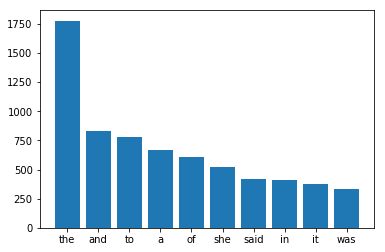

In [3]:
@Pipe
def bar(seq):
    n,l = zip(*enumerate(list(seq)))
    plt.bar(n,[x[1] for x in l])
    plt.xticks(n,labels=[x[0] for x in l])
    plt.show()
    
( open('alice.txt','r').readlines()
| select(lambda x: x.lower().strip().split())
| chain
| groupby(lambda x:x)
| select(lambda x: (x[0],len(list(x[1]))))
| sort(key=lambda x:-x[1])
| take(10)
| bar)

## Time-Stamping Pictures

Let's consider a problem where we need to pit date/time stamp onto a picture.

In [5]:
import cv2
import mPyPl as mp
from mPyPl.utils.image import im_load, show_images
import os, time

show = Pipe(lambda x: show_images(x))

In [20]:
import os
if not os.path.isdir('images'):
    !mkdir images
    !wget https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
    !unzip -q Gates50.zip -d images
    !rm Gates50.zip

--2019-10-01 19:19:28--  https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
Resolving webproxy (webproxy)... 10.36.62.1
Connecting to webproxy (webproxy)|10.36.62.1|:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/Gates50.zip [following]
--2019-10-01 19:19:28--  https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/Gates50.zip
Connecting to webproxy (webproxy)|10.36.62.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 19574121 (19M) [application/zip]
Saving to: ‘Gates50.zip’

Gates50.zip         100%[===================>]  18.67M  1.49MB/s    in 12s     

2019-10-01 19:19:41 (1.52 MB/s) - ‘Gates50.zip’ saved [19574121/19574121]



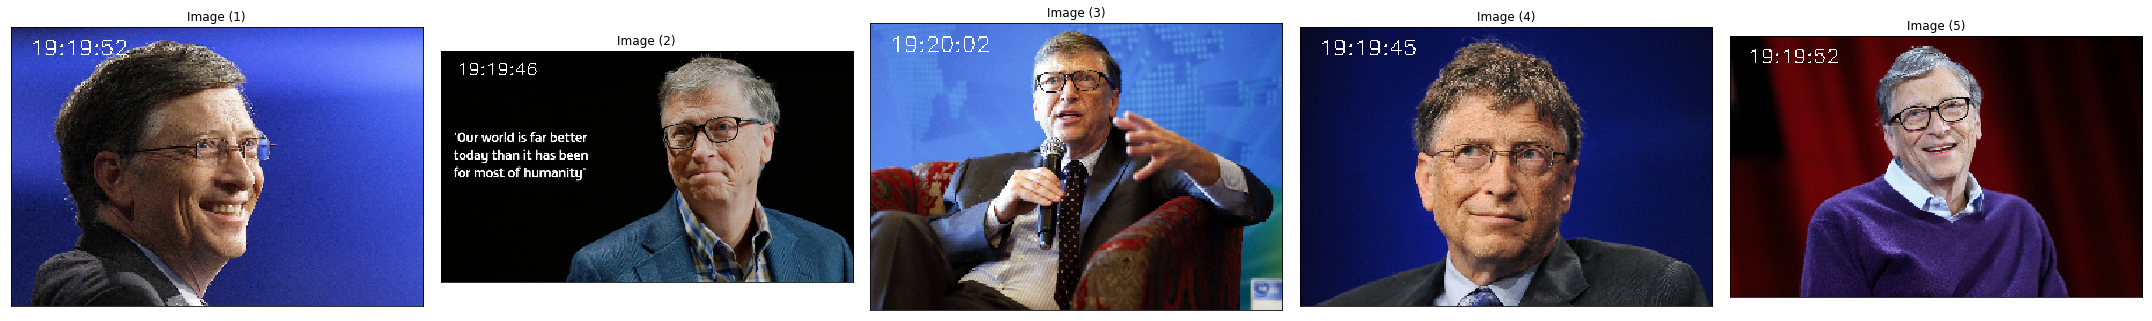

In [12]:
def imprint(img,txt):
    cv2.putText(img,txt, (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    return img

(mp.get_files('images')
 | take(5)
 | select(lambda x: (x,time.ctime(os.stat(x).st_ctime)[10:19]))
 | select(lambda x: (im_load(x[0],size=(None,200)),x[1]))
 | select(lambda x: imprint(*x))
 | show)

## mPyPl Solution

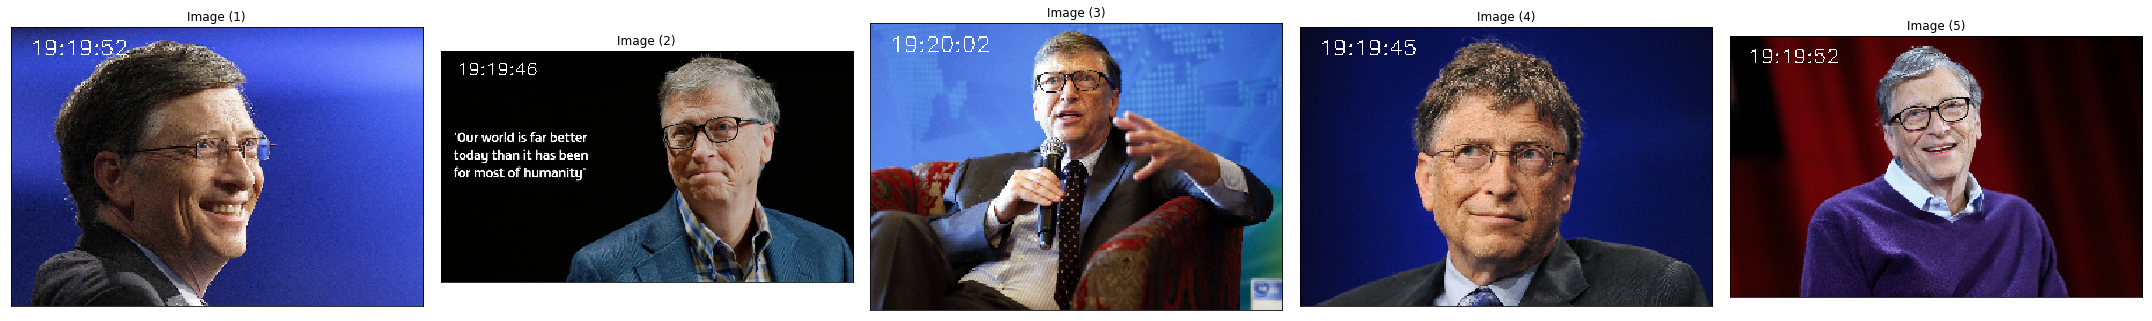

In [19]:
(mp.get_files('images')
 | mp.as_field('fname')
 | mp.take(5)
 | mp.apply('fname','time',lambda x: time.ctime(os.stat(x).st_ctime)[10:19])
 | mp.apply('fname','image',lambda x: im_load(x,size=(None,200)))
 | mp.apply(['image','time'],'res',lambda x: imprint(*x))
 | mp.select_field('res')
 | mp.pexec(show_images))

## Freq Dict via mPyPl

In [20]:
(open('alice.txt','r').readlines()
 | mp.as_field('line')
 | mp.apply('line','word',lambda x: x.lower().strip().split())
 | mp.unroll('word')
 | mp.take(10)
 | mp.as_list)

[{'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': '\ufeffproject'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'gutenberg’s'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'alice’s'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'adventures'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'in'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'wonderland,'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'by'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
  'word': 'lewis'},
 {'line': '\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Car

In [28]:
import itertools
@Pipe
def group_by(seq,fld,fld2):
    l = sorted(list(seq),key=lambda x:x[fld])
    for x,xs in itertools.groupby(l,key=lambda x:x[fld]):
        yield mp.mdict({fld:x,fld2:list(xs)})

(open('alice.txt','r').readlines()
 | mp.as_field('line')
 | mp.apply('line','word',lambda x: x.lower().strip().split())
 | mp.unroll('word')
 | mp.select_fields(['word'])
 | group_by('word','group')
 | mp.apply('group','count',len)
 | mp.delfield('group')
 | sort(key=lambda x:-x['count'])
 | mp.take(10)
 | mp.as_list)

[{'word': 'the', 'count': 1777},
 {'word': 'and', 'count': 833},
 {'word': 'to', 'count': 782},
 {'word': 'a', 'count': 670},
 {'word': 'of', 'count': 610},
 {'word': 'she', 'count': 518},
 {'word': 'said', 'count': 421},
 {'word': 'in', 'count': 412},
 {'word': 'it', 'count': 374},
 {'word': 'was', 'count': 334}]

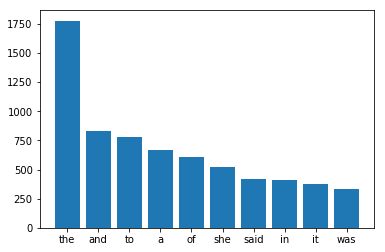

In [31]:
(open('alice.txt','r').readlines()
 | mp.as_field('line')
 | mp.apply('line','word',lambda x: x.lower().strip().split())
 | mp.unroll('word')
 | mp.select_fields(['word'])
 | group_by('word','group')
 | mp.apply('group','count',len)
 | mp.delfield('group')
 | sort(key=lambda x:-x['count'])
 | mp.take(10)
 | mp.select_field(['word','count'])
 | bar)